# Imports

In [1]:
from collections import Counter
import os
import sys

from keras import backend as K
from keras.models import Model
from keras.layers import Activation, concatenate, CuDNNLSTM, Dense, dot, Dropout, Flatten, Input, \
                         Lambda, multiply, Permute, RepeatVector, Reshape, TimeDistributed
from keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12575634969615707502
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3364639388144523470
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


# Config

In [3]:
STORIES_DIR = 'data/cnn/stories/'
story_files = os.listdir(STORIES_DIR)

In [4]:
n_files = len(story_files)
print('Stories in directory: %d' % n_files)

Stories in directory: 92579


In [5]:
characters = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
    'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.', '?', '!',
    ' ', '-', "'", '"', ':', ';', '/', '%', '&', '$', '€', '£', '@',
    '#', '*', '+', '=', '^', '(', ')', '[', ']', '{', '}', '<', '>',
    '_', '~', '|', '\t', '\n'
]

In [6]:
n_characters = len(characters)
n_characters

96

In [7]:
MODEL_NAME = 'deep_lstm_seq2seq_w_attn'
STORIES_TO_PARSE = 75000
MAX_STORY_CHARS_TO_CONSIDER = 1500
MAX_SUMMARY_CHARS_TO_CONSIDER = 250
LSTM_LATENT_DIM = 512
BATCH_SIZE = 50
EPOCHS = 100
BATCHES_PER_LOSSCALC = 10
BEAM_K = 25

# Generate Char Dicts

In [8]:
%%time
idx_2_char = {}
char_2_idx = {}
for i, char in enumerate(characters):
    idx_2_char[i] = char
    char_2_idx[char] = i
    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 40.1 µs


# Configure NNs

## Training

In [9]:
encoder_inputs = Input(shape=(MAX_STORY_CHARS_TO_CONSIDER, n_characters),
                       name='encoder_inputs')

encoder_1 = CuDNNLSTM(
    units=LSTM_LATENT_DIM,
    return_sequences=True,
    return_state=True,
    name='encoder_1'
)
encoder_1_outputs, encoder_1_state_h, encoder_1_state_c = encoder_1(encoder_inputs)
# encoder_1_outputs = Dropout(0.5, name='encoder_1_outputs')(encoder_1_outputs)
# encoder_1_state_h = Dropout(0.5, name='encoder_1_state_h')(encoder_1_state_h)
# encoder_1_state_c = Dropout(0.5, name='encoder_1_state_c')(encoder_1_state_c)
encoder_1_states = [encoder_1_state_h, encoder_1_state_c]

encoder_2 = CuDNNLSTM(
    units=LSTM_LATENT_DIM,
    return_sequences=True,
    return_state=True,
    name='encoder_2'
)   
encoder_2_outputs, encoder_2_state_h, encoder_2_state_c = encoder_2(encoder_1_outputs)
# encoder_2_outputs = Dropout(0.5, name='encoder_2_outputs')(encoder_2_outputs)
# encoder_2_state_h = Dropout(0.5, name='encoder_2_state_h')(encoder_2_state_h)
# encoder_2_state_c = Dropout(0.5, name='encoder_2_state_c')(encoder_2_state_c)
encoder_2_states = [encoder_2_state_h, encoder_2_state_c]

decoder_inputs = Input(shape=(None, n_characters), name='decoder_inputs')
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_1 = CuDNNLSTM(
    units=LSTM_LATENT_DIM, 
    return_sequences=True,
    return_state=True,
    name='decoder_1'
)
decoder_1_outputs, decoder_1_state_h, decoder_1_state_h = decoder_1(
    decoder_inputs,
    initial_state=encoder_1_states
)

decoder_2 = CuDNNLSTM(
    units=LSTM_LATENT_DIM,
    return_sequences=True, 
    return_state=True,
    name='decoder_2'
)
decoder_2_outputs, decoder_2_state_h, decoder_2_state_c = decoder_2(
    decoder_1_outputs,
    initial_state=encoder_2_states
)

encoder_2_outputs_T_gen = Permute((2, 1), name='encoder_outputs_2_T')
encoder_2_outputs_T = encoder_2_outputs_T_gen(encoder_2_outputs)
decoder_2_outputs_dense_gen = Dense(LSTM_LATENT_DIM, name='decoder_2_outputs_dense')
decoder_2_outputs_dense = decoder_2_outputs_dense_gen(decoder_2_outputs)
attention_weights_inputs_gen = Lambda(lambda x: K.batch_dot(x[0], x[1]),
                                      name='attention_weights_inputs')
attention_weights_inputs = attention_weights_inputs_gen([decoder_2_outputs_dense, encoder_2_outputs_T])
attention_weights_gen = Activation('softmax', name='attention_weights')
attention_weights = attention_weights_gen(attention_weights_inputs)
context_gen = Lambda(lambda x: K.batch_dot(x[0], x[1]),
                     name='context')
context = context_gen([attention_weights, encoder_2_outputs])


attention = multiply([decoder_2_outputs, context], 
                     name='attention')

decoder_outputs_gen = Dense(units=n_characters, 
                            activation='softmax',
                            name='decoder_outputs')
decoder_outputs = decoder_outputs_gen(attention)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [10]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [11]:
# plot graph
plot_model(model, to_file=(MODEL_NAME+'.png'))

In [12]:
# summarize layers
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 1500, 96)     0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, None, 96)     0                                            
__________________________________________________________________________________________________
encoder_1 (CuDNNLSTM)           [(None, 1500, 512),  1249280     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_1 (CuDNNLSTM)           [(None, None, 512),  1249280     decoder_inputs[0][0]             
                                                                 encoder_1[0][1]                  
          

## Inference

In [13]:
inf_encoder_model = Model(encoder_inputs, [encoder_2_outputs] + encoder_1_states + encoder_2_states)

In [14]:
# summarize layers
print(inf_encoder_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  (None, 1500, 96)          0         
_________________________________________________________________
encoder_1 (CuDNNLSTM)        [(None, 1500, 512), (None 1249280   
_________________________________________________________________
encoder_2 (CuDNNLSTM)        [(None, 1500, 512), (None 2101248   
Total params: 3,350,528
Trainable params: 3,350,528
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
# plot graph
plot_model(inf_encoder_model, to_file=(MODEL_NAME+'_inf_encoder.png'))

In [16]:
inf_decoder_1_input_state_h = Input(shape=(LSTM_LATENT_DIM,))
inf_decoder_1_input_state_c = Input(shape=(LSTM_LATENT_DIM,))
inf_decoder_1_input_states = [inf_decoder_1_input_state_h, inf_decoder_1_input_state_c]
inf_decoder_1_outputs, inf_decoder_1_state_h, inf_decoder_1_state_c = decoder_1(
    decoder_inputs, initial_state=inf_decoder_1_input_states
)
inf_decoder_1_states = [inf_decoder_1_state_h, inf_decoder_1_state_c]

inf_decoder_2_input_state_h = Input(shape=(LSTM_LATENT_DIM,))
inf_decoder_2_input_state_c = Input(shape=(LSTM_LATENT_DIM,))
inf_decoder_2_input_states = [inf_decoder_2_input_state_h, inf_decoder_2_input_state_c]
inf_decoder_2_outputs, inf_decoder_2_state_h, inf_decoder_2_state_c = decoder_2(
    inf_decoder_1_outputs, initial_state=inf_decoder_2_input_states
)
inf_decoder_2_states = [inf_decoder_2_state_h, inf_decoder_2_state_c]

inf_encoder_2_outputs = Input(shape=(MAX_STORY_CHARS_TO_CONSIDER, LSTM_LATENT_DIM)) # make this none?
inf_encoder_2_outputs_T = encoder_2_outputs_T_gen(inf_encoder_2_outputs)
inf_decoder_2_outputs_dense = decoder_2_outputs_dense_gen(inf_decoder_2_outputs)
inf_attention_weights_inputs = attention_weights_inputs_gen(
    [inf_decoder_2_outputs_dense, inf_encoder_2_outputs_T]
)
inf_attention_weights = attention_weights_gen(inf_attention_weights_inputs)
inf_context = context_gen([inf_attention_weights, inf_encoder_2_outputs])

inf_attention = multiply([inf_decoder_2_outputs, inf_context])

inf_decoder_outputs = decoder_outputs_gen(inf_attention)

inf_decoder_model = Model(
    [decoder_inputs, inf_encoder_2_outputs] + inf_decoder_1_input_states + inf_decoder_2_input_states,
    [inf_decoder_outputs] + inf_decoder_1_states + inf_decoder_2_states
)

In [17]:
# summarize layers
print(inf_decoder_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     (None, None, 96)     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
decoder_1 (CuDNNLSTM)           [(None, None, 512),  1249280     decoder_inputs[0][0]             
                                                                 input_1[0][0]                    
          

In [18]:
# plot graph
plot_model(inf_decoder_model, to_file=(MODEL_NAME+'_inf_decoder.png'))

In [19]:
def get_summary(input_seq, beam_k):
    # Encode the input as state vectors.
    encoded_seq, h1, c1, h2, c2 = inf_encoder_model.predict(input_seq)
    states_1_value = [h1, c1]
    states_2_value = [h2, c2]

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, n_characters))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, char_2_idx['\t']] = 1.

    # Beam search for sequence summary
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    candidate_sentences = [{'sentence': '', 
                            'is_complete': False,
                            'target_seq': target_seq,
                            'states_1_value': states_1_value, 
                            'states_2_value': states_2_value, 
                            'log_prob': 1.0}] # use log prob since conditional probs become tiny
    while not stop_condition:
        tmp_candidate_sentences = []
        for candidate in candidate_sentences:
            if candidate['is_complete']:
                tmp_candidate_sentences.append(candidate)
            else:
                output_probs, h1, c1, h2, c2 = inf_decoder_model.predict(
                    [candidate['target_seq'], encoded_seq]
                    + candidate['states_1_value'] 
                    + candidate['states_2_value']
                )
                output_probs = output_probs[0, 0, :]
                # since only k-best sentences are considered globally, at most need to
                # consider the k-best locally:
                sampled_char_indexes = np.argpartition(output_probs, -beam_k)[-beam_k:]
                for idx in sampled_char_indexes:
                    sampled_char = idx_2_char[idx]
                    sentence = (candidate['sentence'] + sampled_char)
                    # summary is complete when end character is generated or max length reached
                    is_complete = (sampled_char == '\n'
                                   or len(sentence) == MAX_SUMMARY_CHARS_TO_CONSIDER)
                    target_seq = np.zeros((1, 1, n_characters))
                    target_seq[0, 0, idx] = 1.
                    states_1_value = [h1, c1]
                    states_2_value = [h2, c2]
                    log_prob = (candidate['log_prob'] + np.log(output_probs[idx]))
                    new_candidate = {
                        'sentence': sentence, 
                        'is_complete': is_complete,
                        'target_seq': target_seq,
                        'states_1_value': states_1_value, 
                        'states_2_value': states_2_value, 
                        'log_prob': log_prob
                    }
                    tmp_candidate_sentences.append(new_candidate)
        tmp_candidate_sentences = sorted(tmp_candidate_sentences, 
                                         key = lambda candidate: candidate['log_prob'])
        candidate_sentences = tmp_candidate_sentences[-beam_k:]
        
        # stop loop when all candidate sentences are complete
        stop_condition = True
        for candidate in candidate_sentences:
            stop_condition = (stop_condition and candidate['is_complete'])

    
    return candidate_sentences[-1]['sentence'], candidate_sentences

# Model Training


Epoch 0:


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer decoder_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_1/strided_slice_16:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'encoder_1/strided_slice_17:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer decoder_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_2/strided_slice_16:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'encoder_2/strided_slice_17:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '





Story:
DEKALB, Illinois  -- Eric Mace says he thought he was giving his daughter good advice by asking her to sit up front in class.  Ryanne Mace was 19 when she was killed last year in a shooting rampage at Northern Illinois University.  "I'd like you to sit in the front row of every class that you're in and constantly drag information out of these people, and if you don't understand what they're talking about, raise your hand and say, 'I don't get it' until you get it," Mace recalled telling her.  His daughter, 19-year-old Ryanne, took that advice. Now, he wishes she would have sat somewhere else.  Mace believes that Ryanne was probably one of the first to be killed in the Northern Illinois University shootings a year ago, because she was in the front row in the lecture at Cole Hall.  "She was, from what I understand, in the front row of that room and was probably the first one that had shots fired at her after the gentleman that was on stage," Mace said.  "It's not an easy thing 




Story:
DEKALB, Illinois  -- Eric Mace says he thought he was giving his daughter good advice by asking her to sit up front in class.  Ryanne Mace was 19 when she was killed last year in a shooting rampage at Northern Illinois University.  "I'd like you to sit in the front row of every class that you're in and constantly drag information out of these people, and if you don't understand what they're talking about, raise your hand and say, 'I don't get it' until you get it," Mace recalled telling her.  His daughter, 19-year-old Ryanne, took that advice. Now, he wishes she would have sat somewhere else.  Mace believes that Ryanne was probably one of the first to be killed in the Northern Illinois University shootings a year ago, because she was in the front row in the lecture at Cole Hall.  "She was, from what I understand, in the front row of that room and was probably the first one that had shots fired at her after the gentleman that was on stage," Mace said.  "It's not an easy thing 

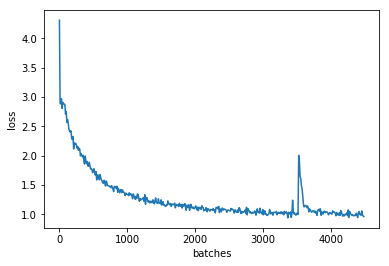




Story:
DEKALB, Illinois  -- Eric Mace says he thought he was giving his daughter good advice by asking her to sit up front in class.  Ryanne Mace was 19 when she was killed last year in a shooting rampage at Northern Illinois University.  "I'd like you to sit in the front row of every class that you're in and constantly drag information out of these people, and if you don't understand what they're talking about, raise your hand and say, 'I don't get it' until you get it," Mace recalled telling her.  His daughter, 19-year-old Ryanne, took that advice. Now, he wishes she would have sat somewhere else.  Mace believes that Ryanne was probably one of the first to be killed in the Northern Illinois University shootings a year ago, because she was in the front row in the lecture at Cole Hall.  "She was, from what I understand, in the front row of that room and was probably the first one that had shots fired at her after the gentleman that was on stage," Mace said.  "It's not an easy thing 

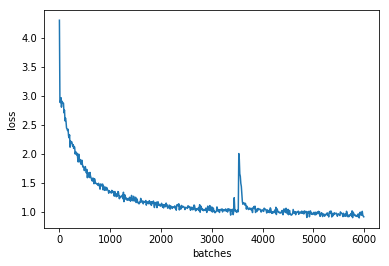




Story:
DEKALB, Illinois  -- Eric Mace says he thought he was giving his daughter good advice by asking her to sit up front in class.  Ryanne Mace was 19 when she was killed last year in a shooting rampage at Northern Illinois University.  "I'd like you to sit in the front row of every class that you're in and constantly drag information out of these people, and if you don't understand what they're talking about, raise your hand and say, 'I don't get it' until you get it," Mace recalled telling her.  His daughter, 19-year-old Ryanne, took that advice. Now, he wishes she would have sat somewhere else.  Mace believes that Ryanne was probably one of the first to be killed in the Northern Illinois University shootings a year ago, because she was in the front row in the lecture at Cole Hall.  "She was, from what I understand, in the front row of that room and was probably the first one that had shots fired at her after the gentleman that was on stage," Mace said.  "It's not an easy thing 

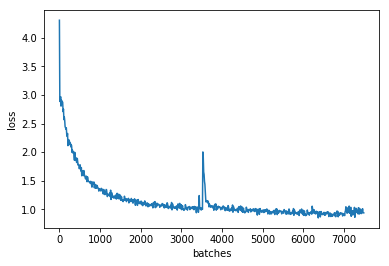




Story:
DEKALB, Illinois  -- Eric Mace says he thought he was giving his daughter good advice by asking her to sit up front in class.  Ryanne Mace was 19 when she was killed last year in a shooting rampage at Northern Illinois University.  "I'd like you to sit in the front row of every class that you're in and constantly drag information out of these people, and if you don't understand what they're talking about, raise your hand and say, 'I don't get it' until you get it," Mace recalled telling her.  His daughter, 19-year-old Ryanne, took that advice. Now, he wishes she would have sat somewhere else.  Mace believes that Ryanne was probably one of the first to be killed in the Northern Illinois University shootings a year ago, because she was in the front row in the lecture at Cole Hall.  "She was, from what I understand, in the front row of that room and was probably the first one that had shots fired at her after the gentleman that was on stage," Mace said.  "It's not an easy thing 

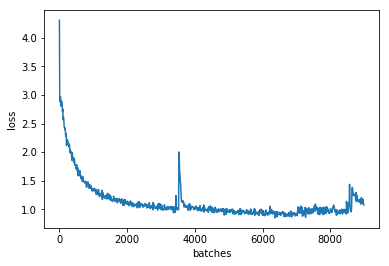




Story:
DEKALB, Illinois  -- Eric Mace says he thought he was giving his daughter good advice by asking her to sit up front in class.  Ryanne Mace was 19 when she was killed last year in a shooting rampage at Northern Illinois University.  "I'd like you to sit in the front row of every class that you're in and constantly drag information out of these people, and if you don't understand what they're talking about, raise your hand and say, 'I don't get it' until you get it," Mace recalled telling her.  His daughter, 19-year-old Ryanne, took that advice. Now, he wishes she would have sat somewhere else.  Mace believes that Ryanne was probably one of the first to be killed in the Northern Illinois University shootings a year ago, because she was in the front row in the lecture at Cole Hall.  "She was, from what I understand, in the front row of that room and was probably the first one that had shots fired at her after the gentleman that was on stage," Mace said.  "It's not an easy thing 

In [ ]:
batch = 0
batches = []
losses = []
for epoch in np.arange(EPOCHS):
    print('\nEpoch %d:' % epoch)
    for start_file_idx in tqdm_notebook(np.arange(0, STORIES_TO_PARSE, BATCH_SIZE)):
        end_file_idx = min(start_file_idx+BATCH_SIZE, STORIES_TO_PARSE)

        # get story and summary strings
        stories = []
        summaries = []
        for filename in story_files[start_file_idx:end_file_idx]:
            f = open(STORIES_DIR+filename, 'r')
            combo = f.read()
            splt = combo.split('@highlight')

            story = splt[0].replace('(CNN)', '').replace('\n', ' ')
            stories.append(story)

            summary = '. '.join(splt[1:]).replace('\n', '')
            summary = '\t ' + summary + ' \n'
            summaries.append(summary)

            f.close()
        N = len(stories)

        # embed stories
        stories_embeddings = np.zeros(
            (N, MAX_STORY_CHARS_TO_CONSIDER, n_characters),
            dtype='float32'
        )
        for i, story in enumerate(stories):
            for j, char in enumerate(story):
                if j < MAX_STORY_CHARS_TO_CONSIDER:
                    if char in char_2_idx:
                        k = char_2_idx[char]
                        stories_embeddings[i, j, k] = 1.
                else:
                    break        
        
        # embed summaries
        summaries_embeddings_input = np.zeros(
            (N, MAX_SUMMARY_CHARS_TO_CONSIDER, n_characters),
            dtype='float32'
        )   
        summaries_embeddings_target = np.zeros(
            (N, MAX_SUMMARY_CHARS_TO_CONSIDER, n_characters),
            dtype='float32'
        )
        for i, summary in enumerate(summaries):
            for j, char in enumerate(summary):
                if j <= MAX_SUMMARY_CHARS_TO_CONSIDER:
                    if char in char_2_idx:
                        k = char_2_idx[char]
                        if j < MAX_SUMMARY_CHARS_TO_CONSIDER:
                            summaries_embeddings_input[i, j, k] = 1.
                        if j > 0:
                            summaries_embeddings_target[i, j-1, k] = 1.
                else:
                    break

        # update model
        model.train_on_batch([stories_embeddings, summaries_embeddings_input], summaries_embeddings_target)
        if (batch % BATCHES_PER_LOSSCALC) == 0:
            batches.append(batch)
            loss = model.test_on_batch([stories_embeddings, summaries_embeddings_input], summaries_embeddings_target)
            losses.append(loss)
        batch += 1
    
    
    # save model:
    model.save(MODEL_NAME+'.h5')
    
    # plot loss
    plt.plot(batches, losses)
    plt.ylabel('loss')
    plt.xlabel('batches')
    plt.show()
    plt.close()
    
    # spot check performance
    for i in range(2):
        to_summarize = stories_embeddings[i].reshape(1, MAX_STORY_CHARS_TO_CONSIDER, n_characters)
        generated_summary, candidate_sentences = get_summary(to_summarize, BEAM_K)
        print('\n\n')
        print('Story:')
        print(stories[i])
        print('\nActual Summary:')
        print(summaries[i])
        print('\nGenerated Summaries:')
        for candidate in candidate_sentences[-min(5, BEAM_K):]:
            print('\n')
            print(candidate['sentence'])

## Spot Check Performance

In [ ]:
for i in range(2):
    to_summarize = stories_embeddings[i].reshape(1, MAX_STORY_CHARS_TO_CONSIDER, n_characters)
    generated_summary, candidate_sentences = get_summary(to_summarize, BEAM_K)
    print('\n\n')
    print('Story:')
    print(stories[i])
    print('\nActual Summary:')
    print(summaries[i])
    print('\nGenerated Summaries:')
    for candidate in candidate_sentences[-min(5, BEAM_K):]:
        print('\n')
        print(candidate['sentence'])